In [1]:
import pandas as pd
import numpy as np
import modeltest as deep
import experiment as exp
import myutil as util
import tensorflow as tf
from itertools import product

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
import importlib
importlib.reload(deep)
importlib.reload(exp)

<module 'experiment' from 'c:\\Users\\kyeongtaek\\generative_model\\hggis_boson\\experiment.py'>

In [29]:

#파일 읽기
filepath_german_csv = 'training.csv'
d_german_df = pd.read_csv(filepath_german_csv)

#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

train = label_encoder(d_german_df, make_label_map(d_german_df))
train.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,1
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,1
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1


In [30]:
#numpy 변환
d_german_np = np.array(d_german_df)

# sample 수, 특징 수 등 계산
n_row = d_german_np.shape[0]
n_features = d_german_np.shape[1]-1

# 입력과 출력 데이터 분리
x = d_german_np[:, :n_features]
y = d_german_np[:, n_features]

#정규화
x_norm = (x - np.min(x,0))/ (np.max(x,0) - np.min(x,0))
y_norm = (y - np.min(y,0))/ (np.max(y,0) - np.min(y,0))

In [31]:
y

array([0., 1., 1., ..., 0., 1., 1.])

In [32]:
import tensorflow_addons as tfa

Triplet Loss

Epoch 1/200
1563/1563 - 23s - loss: 0.4516 - val_loss: 0.4804 - 23s/epoch - 14ms/step
Epoch 2/200
1563/1563 - 22s - loss: 0.4454 - val_loss: 0.4462 - 22s/epoch - 14ms/step
Epoch 3/200
1563/1563 - 22s - loss: 0.4104 - val_loss: 0.4043 - 22s/epoch - 14ms/step
Epoch 4/200
1563/1563 - 21s - loss: 0.3862 - val_loss: 0.3625 - 21s/epoch - 14ms/step
Epoch 5/200
1563/1563 - 22s - loss: 0.3694 - val_loss: 0.3952 - 22s/epoch - 14ms/step
Epoch 6/200
1563/1563 - 22s - loss: 0.3616 - val_loss: 0.3495 - 22s/epoch - 14ms/step
Epoch 7/200
1563/1563 - 22s - loss: 0.3502 - val_loss: 0.4017 - 22s/epoch - 14ms/step
Epoch 8/200
1563/1563 - 21s - loss: 0.3383 - val_loss: 0.3352 - 21s/epoch - 14ms/step
Epoch 9/200
1563/1563 - 21s - loss: 0.3313 - val_loss: 0.3093 - 21s/epoch - 14ms/step
Epoch 10/200
1563/1563 - 21s - loss: 0.3261 - val_loss: 0.3346 - 21s/epoch - 14ms/step
Epoch 11/200
1563/1563 - 22s - loss: 0.3180 - val_loss: 0.3206 - 22s/epoch - 14ms/step
Epoch 12/200
1563/1563 - 22s - loss: 0.3151 - val_lo

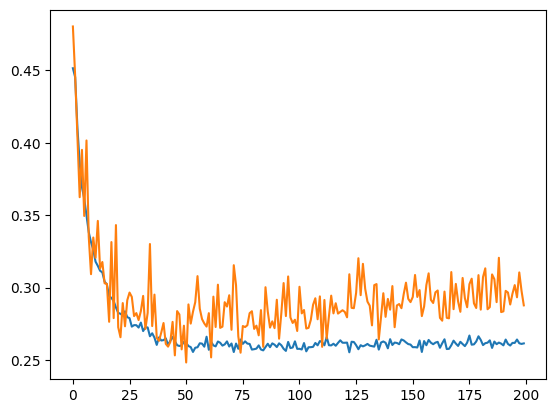

In [10]:
# 10fold validation 수행여부
bTenFoldValidation = False
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.0, val_ratio=0.2)

    # 모델 불러오기 & 컴파일
    g = deep.encoder(x.shape[1:])
        
    g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

    hist = g.fit(x_train, y_train, epochs=200, batch_size = 128, validation_data=(x_val, y_val), verbose=2)
    # 결과 출력

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기

    N = 10
    total = 0
    nClass = 2
    cm = np.zeros([N, nClass, nClass])
    for i in range(N):
        # Train/Test 데이터 분할
        [x_train, x_test, y_train, y_test] = exp.split_data_for_N_fold_validation(x_norm, y, fold=N, idx=i)

        # 모델 불러오기 & 컴파일
        g = deep.encoder(x.shape[1:])
        
        g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

        # 학습
        hist = g.fit(x_train, y_train, epochs=2000, batch_size = 256, validation_data=(x_test, y_test))
        
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['accuracy'])
    #plt.plot(result.val_acc)
        plt.show()


Triplet 전이학습

In [21]:
# 10fold validation 수행여부
bTenFoldValidation = True
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.0, val_ratio=0.2)

    # 모델 불러오기 & 컴파일
    g = deep.encoder(x.shape[1:])
        
    g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

    hist = g.fit(x_train, y_train, epochs=500, batch_size = 16, validation_data=(x_val, y_val))
    
    g.trainable=False
    m = deep.final_model(x.shape[1:], g, (1296,))
    
    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    # 학습시 사용하는 옵션
    train_options = exp.TrainParams(m, epochs=1000, batch_size_per_class=16)

    # 학습
    result = exp.train_batches_with_random_selection(train_options, x_train, y_train, x_val, y_val)

    # 테스트
    if(x_test.shape[0] > 0):
        test_acc_tmp = np.sum(np.argmax(np.squeeze(result.model.predict(x_val)), -1) == y_val) / y_val.shape[0]
        print(f'test_acc:{test_acc_tmp}')
    # 결과 출력

    plt.plot(result.train_acc)
    plt.plot(result.val_acc)
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기
    
    # General settings
    base_settings = {'epochs': 300}
    # Grid search
    grid = {
        'batch_size': [32, 64, 128],
        'learning_rate': [0.001, 0.0001]
    }

    N = 10
    total = 0
    nClass = 2
    cm = np.zeros([N, nClass, nClass])
    for i in range(N):
        # Train/Test 데이터 분할
        [x_train, x_test, y_train, y_test] = exp.split_data_for_N_fold_validation(x_norm, y, fold=N, idx=i)

        # 모델 불러오기 & 컴파일
        g = deep.encoder(x.shape[1:])
        
        g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

        # 학습
        hist = g.fit(x_train, y_train, epochs=200, batch_size = 64)
        g.trainable=False
        m = deep.final_model(x.shape[1:], g, g.output_shape[1:])
        
        m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        
        # 학습시 사용하는 옵션
        train_options = exp.TrainParams(m, epochs=300, batch_size_per_class=32)
        
        result = exp.train_batches_with_random_selection(train_options, x_train, y_train, bVerbose=False)
        
        # 테스트
        o = np.argmax(np.squeeze(result.model.predict(x_test)), -1)
        test_acc_tmp = np.sum(o == y_test) / y_test.shape[0]
        #for j in range(y_test.shape[0]):
            #cm[i, int(y_test[j]), int(o[j])] += 1  #Confusion Matrix 계산

        # 결과 출력
        print(f'{i}/{N}\t test_acc:{test_acc_tmp}')
        plt.plot(result.train_acc)
        plt.plot(result.val_acc)
        plt.show()
        total = total + test_acc_tmp

ave = total/10
print(f'average accuracy : {ave}')

Epoch 1/200
2591/3516 [=====================>........] - ETA: 9s - loss: 0.4828

KeyboardInterrupt: 

Gird Search

782/782 [==============================] - 2s 3ms/step
0/10	 test_acc:0.77464


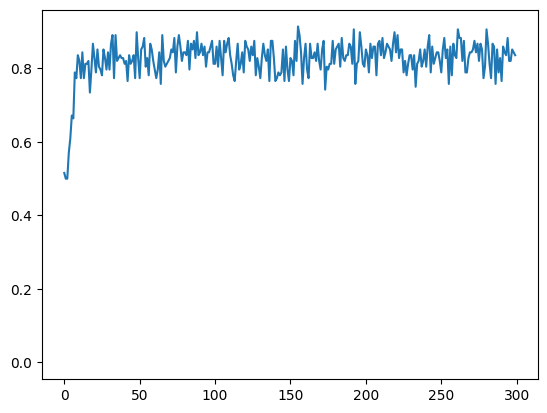

782/782 [==============================] - 2s 3ms/step
1/10	 test_acc:0.7936


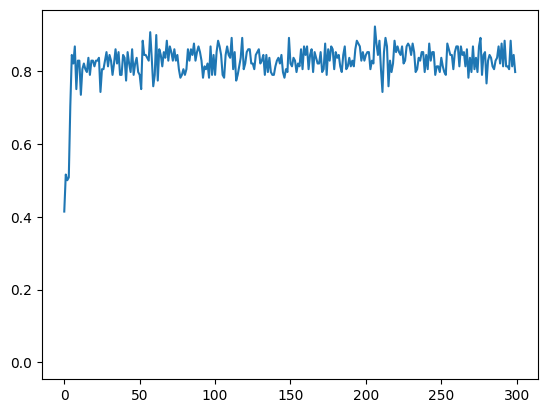

782/782 [==============================] - 3s 3ms/step
2/10	 test_acc:0.80032


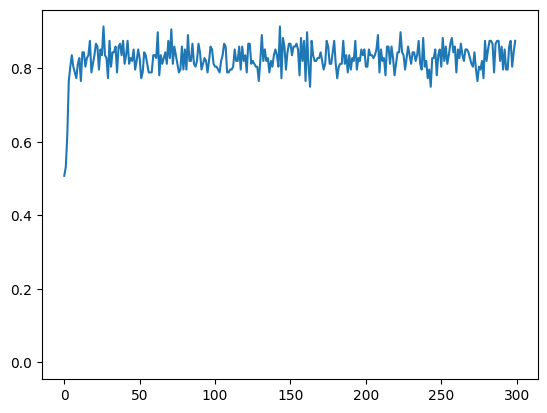

782/782 [==============================] - 2s 3ms/step
3/10	 test_acc:0.78544


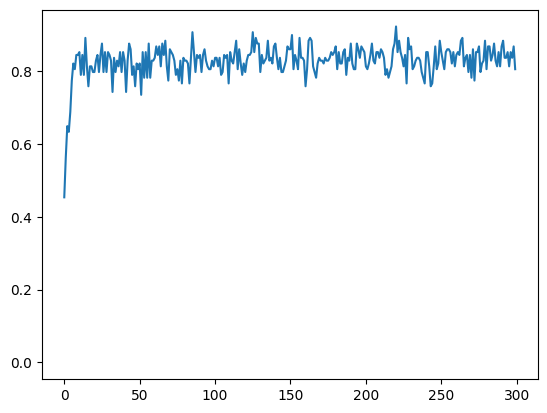

782/782 [==============================] - 3s 3ms/step
4/10	 test_acc:0.79784


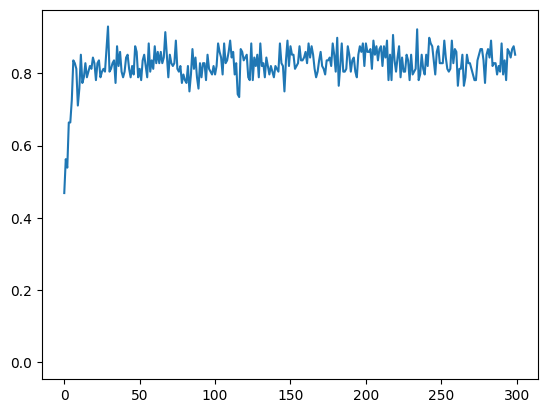

782/782 [==============================] - 3s 3ms/step
5/10	 test_acc:0.78372


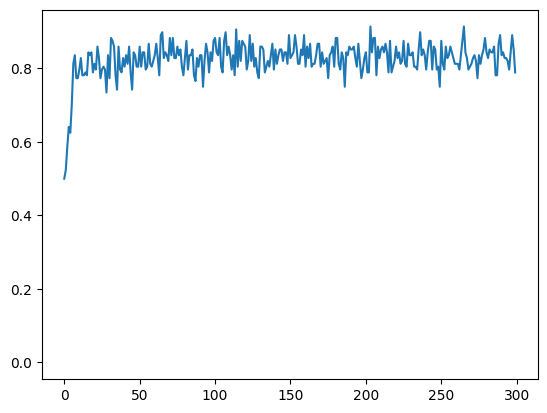

782/782 [==============================] - 3s 3ms/step
6/10	 test_acc:0.80308


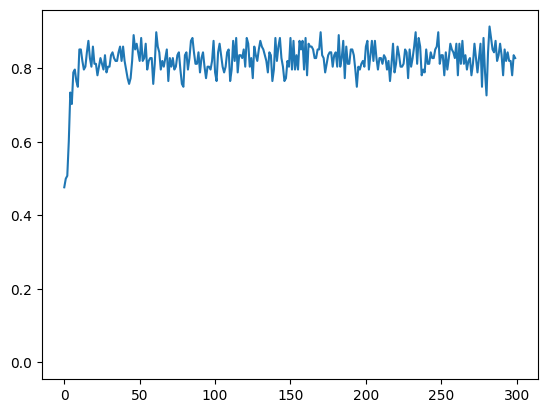

782/782 [==============================] - 3s 3ms/step
7/10	 test_acc:0.8002


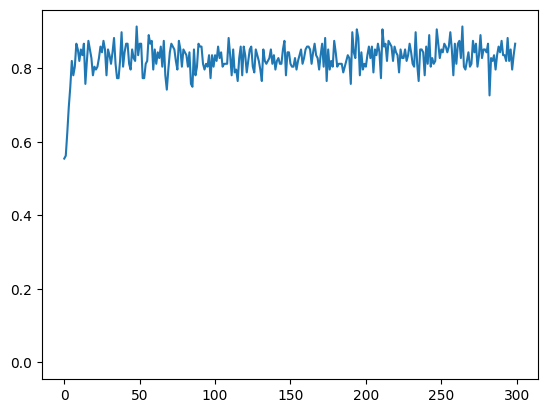

782/782 [==============================] - 2s 3ms/step
8/10	 test_acc:0.8006


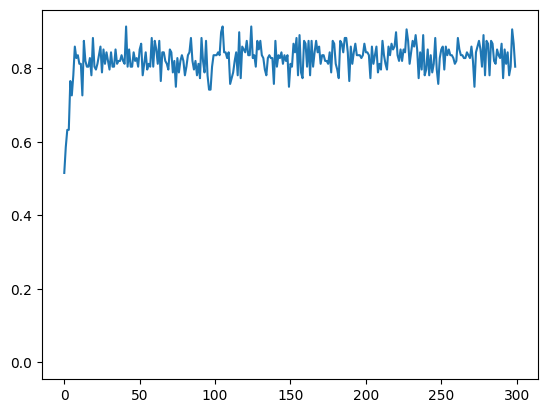

782/782 [==============================] - 3s 3ms/step
9/10	 test_acc:0.7692


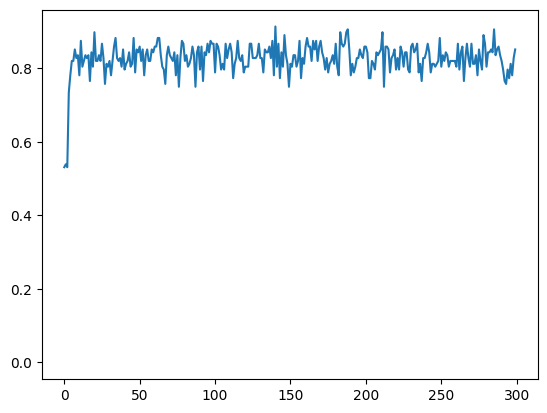

average accuracy : 0.7908639999999999
average loss : [0.70265941 0.68726013 0.67677369 0.65956874 0.63541975 0.59083436
 0.5393212  0.47503892 0.4523427  0.45350377 0.47284229 0.48700845
 0.49703678 0.44084752 0.42950494 0.43493106 0.41000161 0.43385947
 0.42900753 0.42068229 0.41876194 0.42857721 0.40522364 0.41423477
 0.42021476 0.38221478 0.37012019 0.40845294 0.41946403 0.39135475
 0.40420647 0.40520496 0.39645114 0.38581538 0.38838701 0.40945402
 0.39586104 0.38970826 0.40202005 0.36477624 0.39753473 0.39685229
 0.37974436 0.37859628 0.39763765 0.41429083 0.36919372 0.39917023
 0.35350501 0.38089862 0.38077803 0.39191841 0.3869363  0.36871523
 0.36590982 0.40879209 0.3905772  0.38618222 0.36572535 0.40706585
 0.36919917 0.35348799 0.3734676  0.37640214 0.37732611 0.36041224
 0.37923831 0.38268471 0.37590028 0.38582934 0.36359804 0.35887183
 0.37931556 0.36459373 0.41265846 0.39795971 0.38662779 0.39842249
 0.41448722 0.39223513 0.39095506 0.39169547 0.37735713 0.40649259
 0.373630

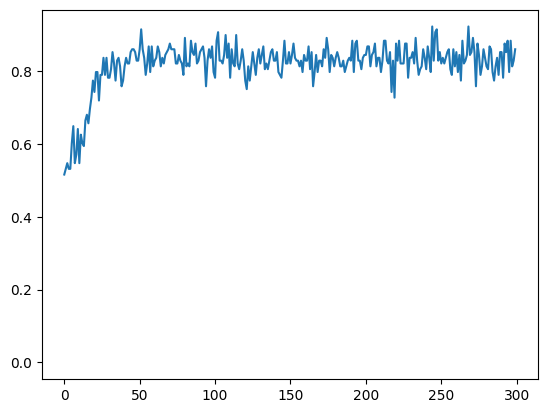

782/782 [==============================] - 3s 3ms/step
1/10	 test_acc:0.82008


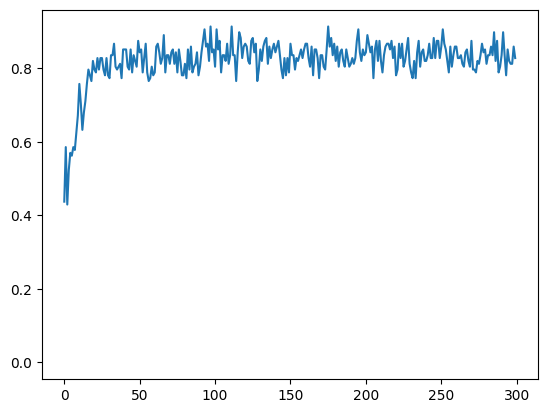

782/782 [==============================] - 2s 3ms/step
2/10	 test_acc:0.81632


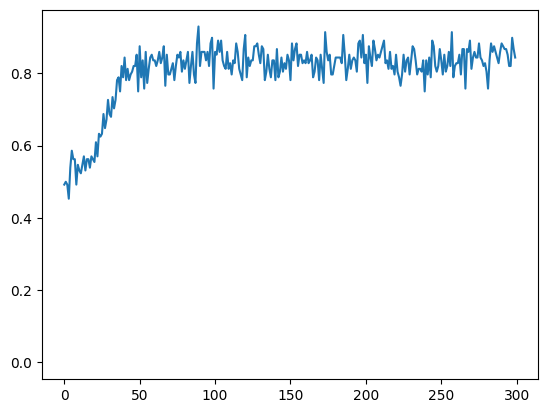

782/782 [==============================] - 2s 3ms/step
3/10	 test_acc:0.81524


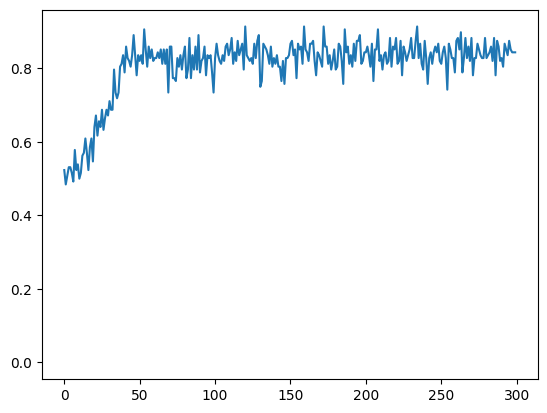

782/782 [==============================] - 3s 3ms/step
4/10	 test_acc:0.81616


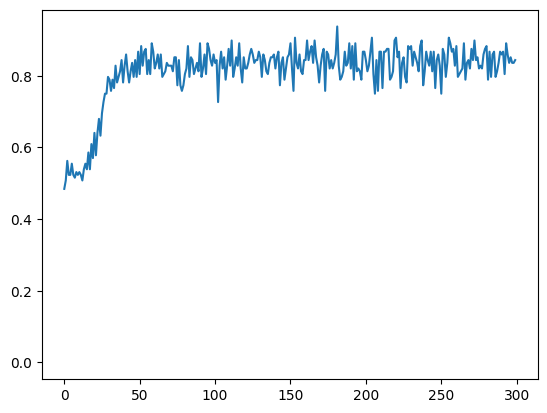

782/782 [==============================] - 3s 3ms/step
5/10	 test_acc:0.8104


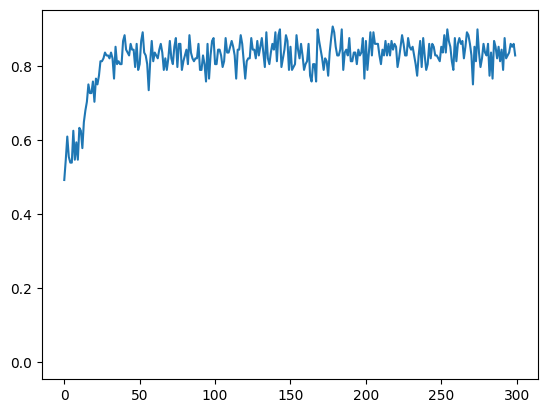

782/782 [==============================] - 2s 3ms/step
6/10	 test_acc:0.81708


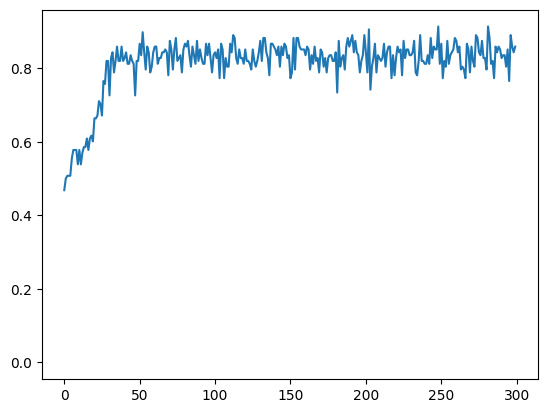

782/782 [==============================] - 2s 3ms/step
7/10	 test_acc:0.8132


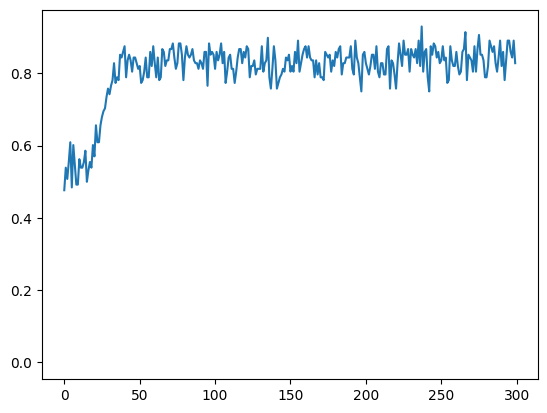

782/782 [==============================] - 3s 3ms/step
8/10	 test_acc:0.82436


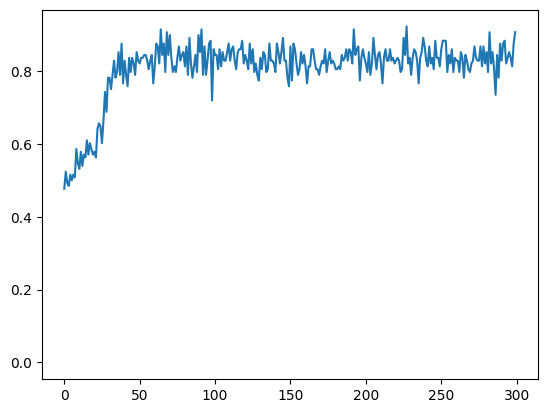

782/782 [==============================] - 2s 3ms/step
9/10	 test_acc:0.81636


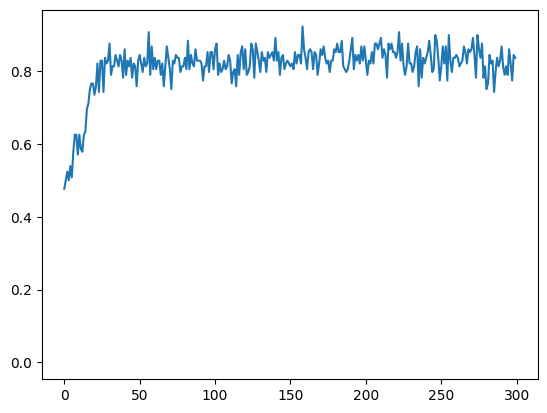

average accuracy : 0.8166839999999999
average loss : [0.69991888 0.69429106 0.69270524 0.68829504 0.68435721 0.682602
 0.68041927 0.67974985 0.6748362  0.67377647 0.67041909 0.66892421
 0.67061248 0.66535145 0.65938032 0.65771541 0.65697715 0.64948198
 0.65069215 0.64323786 0.64223165 0.63559611 0.63030946 0.61763725
 0.61445644 0.61055712 0.60550283 0.59436046 0.58596282 0.57952209
 0.57349474 0.56766233 0.5516222  0.538574   0.53999262 0.52523965
 0.51924689 0.50306632 0.50332289 0.48917819 0.47402583 0.47004757
 0.47180628 0.46669168 0.43766139 0.45741474 0.42824907 0.42928823
 0.43058134 0.42988749 0.41223526 0.39494168 0.41340102 0.3895064
 0.40718864 0.4483372  0.41601143 0.43492296 0.39994411 0.41586605
 0.40785832 0.39282599 0.38724771 0.38813701 0.40462015 0.38947057
 0.38787576 0.40878886 0.38298244 0.40894341 0.37447627 0.38699536
 0.40538312 0.38598718 0.39496282 0.40193851 0.36713775 0.37713126
 0.4208603  0.40230156 0.3710883  0.39781435 0.36449221 0.38083114
 0.37531735 

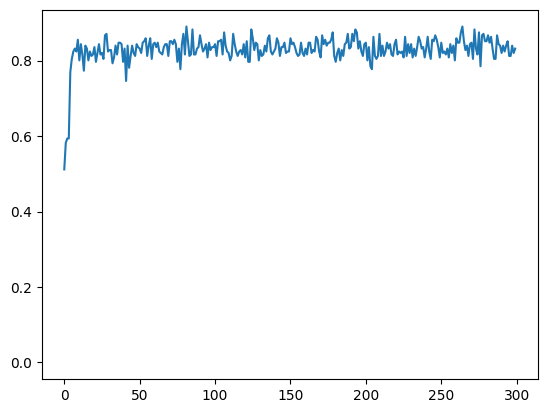

782/782 [==============================] - 3s 3ms/step
1/10	 test_acc:0.81132


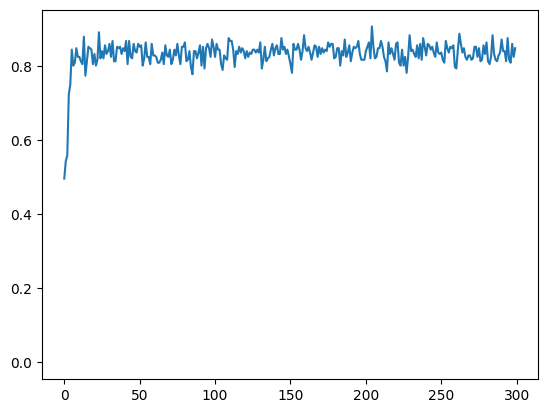

782/782 [==============================] - 2s 3ms/step
2/10	 test_acc:0.80928


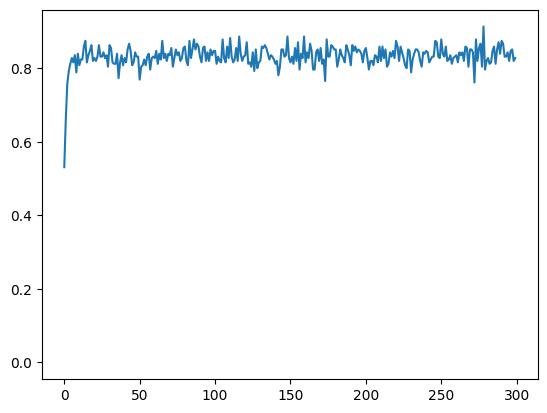

782/782 [==============================] - 3s 3ms/step
3/10	 test_acc:0.7946


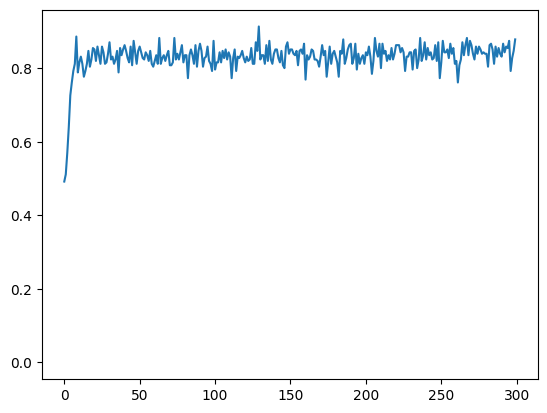

782/782 [==============================] - 3s 3ms/step
4/10	 test_acc:0.78536


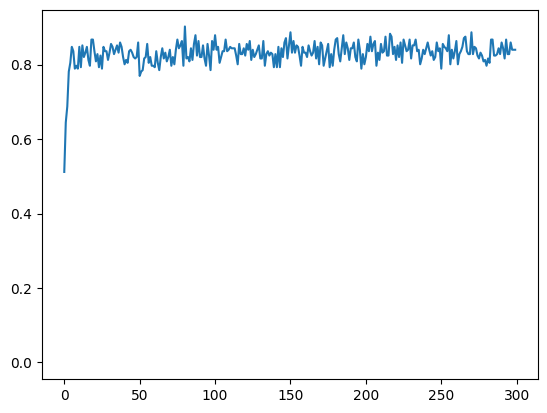

782/782 [==============================] - 2s 3ms/step
5/10	 test_acc:0.80432


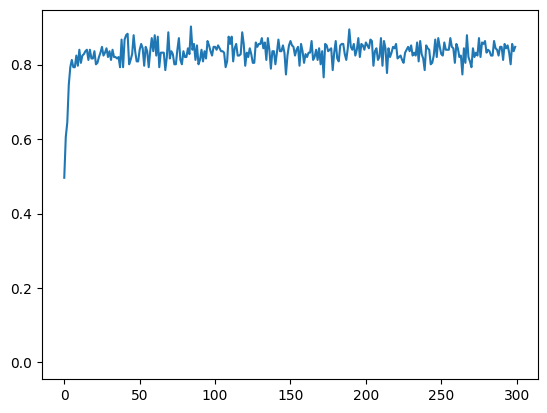

782/782 [==============================] - 3s 3ms/step
6/10	 test_acc:0.79016


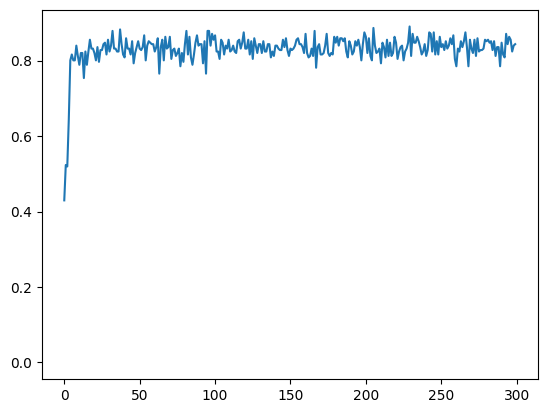

782/782 [==============================] - 3s 3ms/step
7/10	 test_acc:0.80808


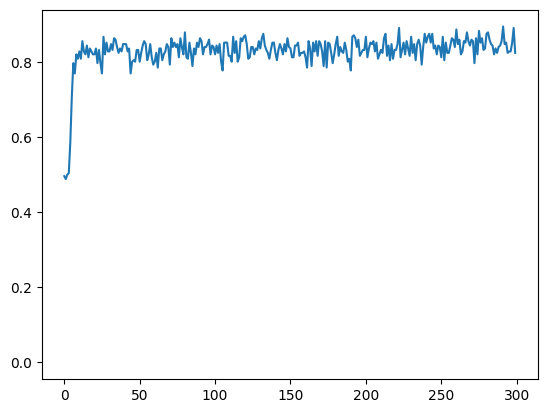

782/782 [==============================] - 3s 3ms/step
8/10	 test_acc:0.80164


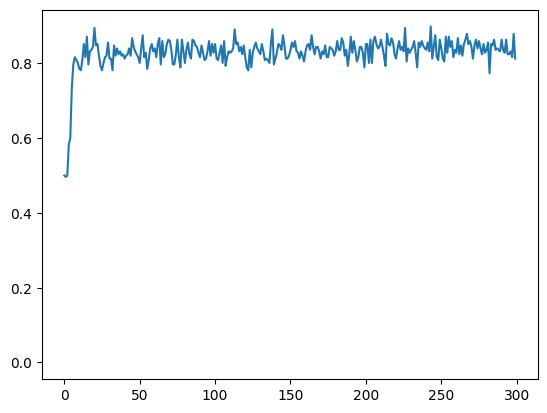

782/782 [==============================] - 2s 3ms/step
9/10	 test_acc:0.76756


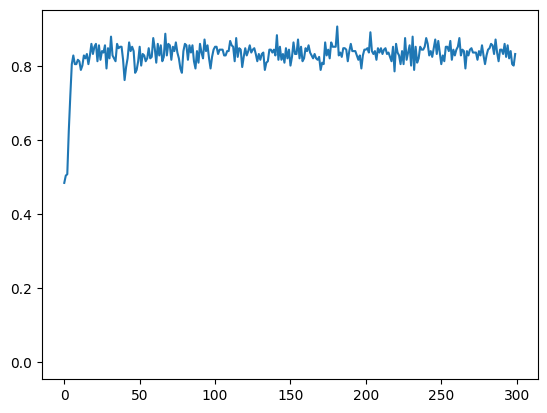

average accuracy : 0.796968
average loss : [0.70368584 0.67886329 0.66485019 0.63548261 0.58878466 0.54413187
 0.50916212 0.49498179 0.45560581 0.46053079 0.45869301 0.43932023
 0.43505557 0.41980188 0.42714925 0.40920451 0.42198453 0.3977349
 0.37944942 0.3917825  0.3864653  0.40913359 0.39189825 0.39016395
 0.40348193 0.4030591  0.37295326 0.38021717 0.37880427 0.37853674
 0.36824172 0.3675666  0.36776307 0.38507298 0.39157524 0.36686899
 0.38865768 0.36293481 0.36051134 0.38585844 0.37704346 0.37101708
 0.37892894 0.37652219 0.3840148  0.37741765 0.36450515 0.37324973
 0.38341968 0.37391741 0.38941379 0.3823584  0.37028221 0.37787665
 0.3760072  0.38328575 0.38534224 0.37003064 0.37221876 0.3722866
 0.36471739 0.36710301 0.37084879 0.38384085 0.38164808 0.37328328
 0.37426155 0.35158149 0.36318721 0.36274409 0.36592519 0.38315328
 0.36621219 0.37733617 0.36774704 0.35703384 0.35406842 0.38520983
 0.35990926 0.37411817 0.35108548 0.36437353 0.40080203 0.35836892
 0.37623106 0.3815771

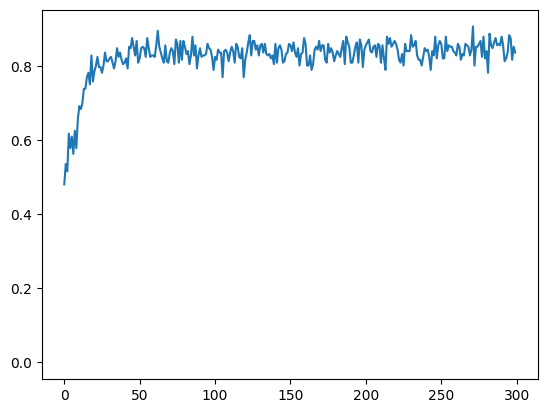

782/782 [==============================] - 3s 3ms/step
1/10	 test_acc:0.8132


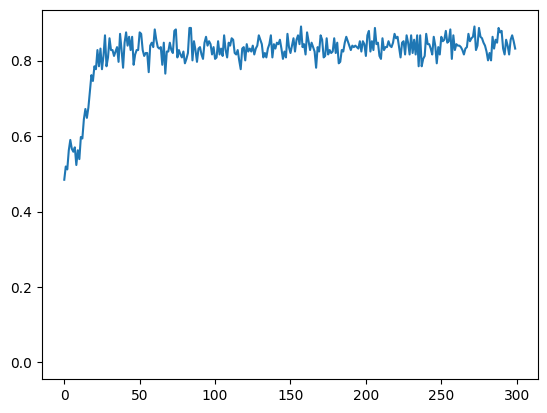

782/782 [==============================] - 3s 3ms/step
2/10	 test_acc:0.80932


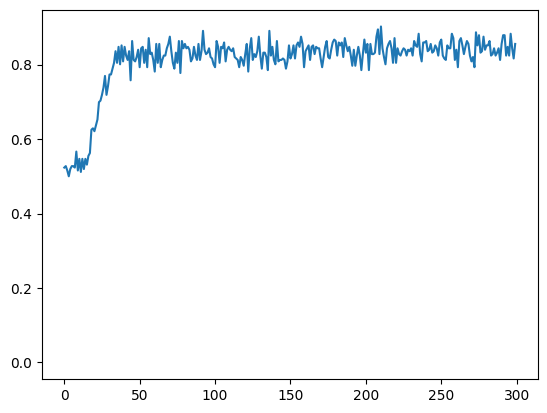

782/782 [==============================] - 2s 3ms/step
3/10	 test_acc:0.81912


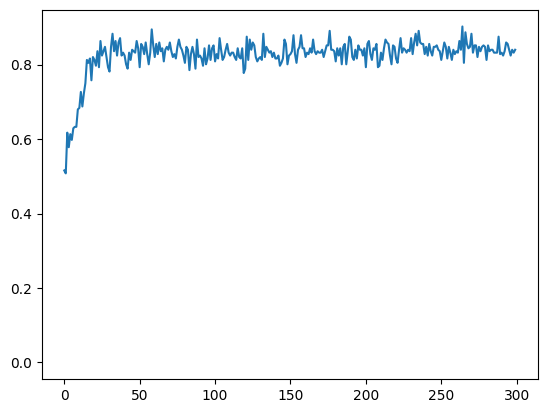

782/782 [==============================] - 2s 3ms/step
4/10	 test_acc:0.81576


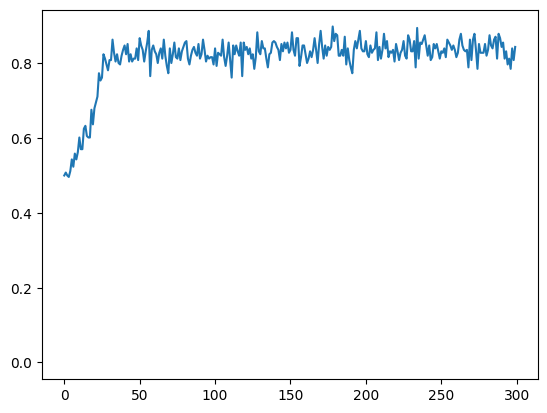

782/782 [==============================] - 2s 3ms/step
5/10	 test_acc:0.81688


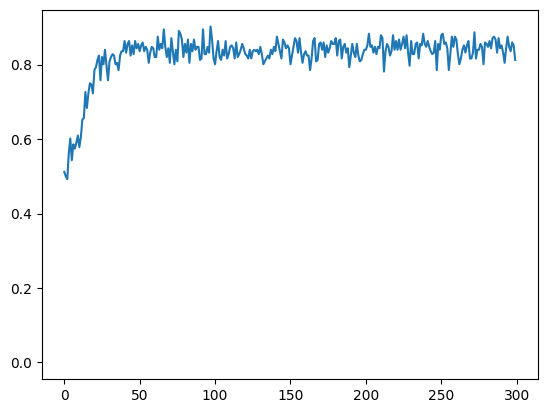

782/782 [==============================] - 3s 3ms/step
6/10	 test_acc:0.81964


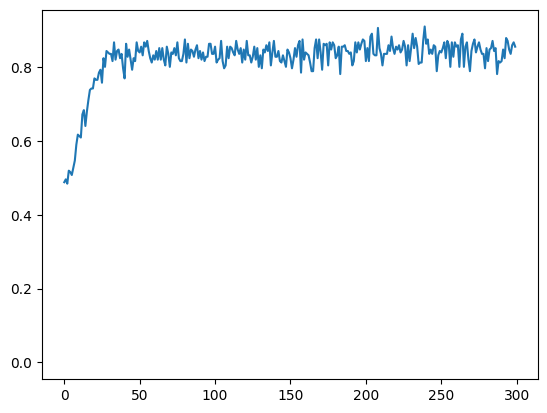

782/782 [==============================] - 3s 3ms/step
7/10	 test_acc:0.81964


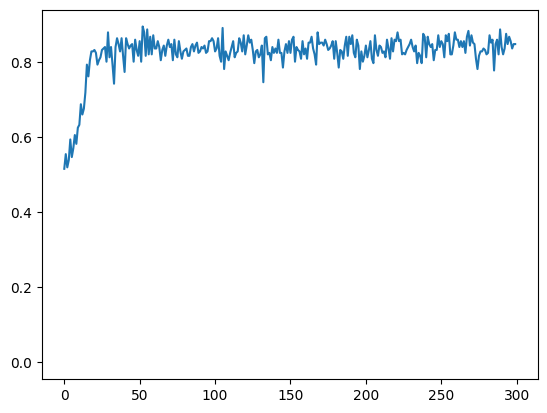

782/782 [==============================] - 2s 3ms/step
8/10	 test_acc:0.82188


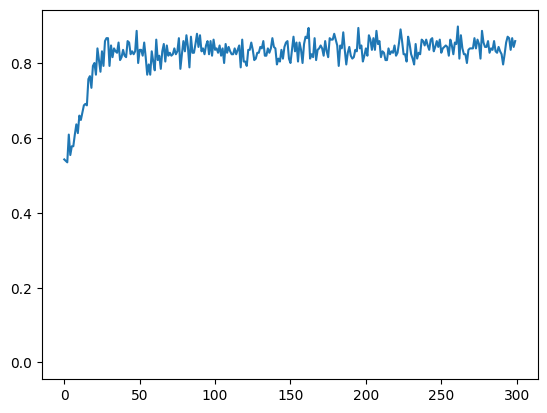

782/782 [==============================] - 2s 3ms/step
9/10	 test_acc:0.81364


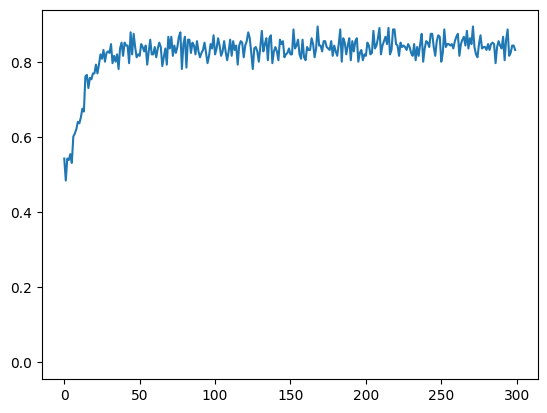

average accuracy : 0.816244
average loss : [0.70003211 0.69425723 0.69010633 0.68382562 0.67978938 0.68048124
 0.67581753 0.67280687 0.675159   0.66692299 0.66745456 0.65729272
 0.65730668 0.6516888  0.6476437  0.63884626 0.63138425 0.62763925
 0.61753895 0.61274472 0.60026413 0.59991079 0.58728094 0.57572187
 0.56547934 0.55939102 0.54236383 0.5257628  0.52238905 0.5140791
 0.50392053 0.47759343 0.47169703 0.47290175 0.45288485 0.44513197
 0.44665015 0.42263097 0.42345977 0.43247028 0.42907366 0.4143822
 0.40084587 0.39506481 0.40897439 0.3988212  0.41047649 0.39923723
 0.39124866 0.42154392 0.39029    0.37492295 0.37726988 0.37746525
 0.391028   0.38511077 0.41237151 0.3980859  0.38747224 0.38810261
 0.39004741 0.37319932 0.37693552 0.36796162 0.3896881  0.38701463
 0.37501726 0.3982056  0.39200711 0.37380014 0.37730961 0.36581993
 0.39939091 0.37931636 0.37476076 0.38033416 0.35942524 0.38021517
 0.38020138 0.37020352 0.3620186  0.37429614 0.36187776 0.37682854
 0.35931418 0.3647997

In [33]:
# 10fold validation 수행여부
bTenFoldValidation = True
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.0, val_ratio=0.2)

    # 모델 불러오기 & 컴파일
    g = deep.encoder(x.shape[1:])
        
    g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

    hist = g.fit(x_train, y_train, epochs=500, batch_size = 16, validation_data=(x_val, y_val))
    
    g.trainable=False
    m = deep.final_model(x.shape[1:], g, (1296,))
    
    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    # 학습시 사용하는 옵션
    train_options = exp.TrainParams(m, epochs=1000, batch_size_per_class=16)

    # 학습
    result = exp.train_batches_with_random_selection(train_options, x_train, y_train, x_val, y_val)

    # 테스트
    if(x_test.shape[0] > 0):
        test_acc_tmp = np.sum(np.argmax(np.squeeze(result.model.predict(x_val)), -1) == y_val) / y_val.shape[0]
        print(f'test_acc:{test_acc_tmp}')
    # 결과 출력

    plt.plot(result.train_acc)
    plt.plot(result.val_acc)
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기
    
    # hyperparameters
    
    nbatch_size = [64, 128]
    nlearning_rate = [0.001, 0.0001]
    nepochs  = [300]
    
    cols = ['batch_size', 'learning_rate', 'epochs', 'test acc', 'loss']
    perform_df = pd.DataFrame(columns = cols)
    
    #grid search
    g_i = 0

    N = 10
    nClass = 2
    cm = np.zeros([N, nClass, nClass])
    
    for bs, lr, e in product(nbatch_size, nlearning_rate, nepochs):
        g_i += 1
        total = 0
        total_loss = 0
        for i in range(N):
            # Train/Test 데이터 분할
            [x_train, x_test, y_train, y_test] = exp.split_data_for_N_fold_validation(x_norm, y, fold=N, idx=i)

            # 모델 불러오기 & 컴파일
            g = deep.encoder(x.shape[1:])
            
            g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

            # 학습
            hist = g.fit(x_train, y_train, epochs=100, batch_size = 64, verbose=0)
            g.trainable=False
            m = deep.final_model(x.shape[1:], g, g.output_shape[1:])
            
            m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
            
            # 학습시 사용하는 옵션
            train_options = exp.TrainParams(m, epochs=e, batch_size_per_class=bs)
            
            result = exp.train_batches_with_random_selection(train_options, x_train, y_train, bVerbose=False)
            
            total_loss = total_loss + result.train_loss
            # 테스트
            o = np.argmax(np.squeeze(result.model.predict(x_test)), -1)
            test_acc_tmp = np.sum(o == y_test) / y_test.shape[0]
            #for j in range(y_test.shape[0]):
                #cm[i, int(y_test[j]), int(o[j])] += 1  #Confusion Matrix 계산

            # 결과 출력
            print(f'{i}/{N}\t test_acc:{test_acc_tmp}')
            plt.plot(result.train_acc)
            plt.plot(result.val_acc)
            plt.show()
            total = total + test_acc_tmp
        ave = total/10
        avl = total_loss/10
        perform_df.loc[g_i] = [bs, lr, e, ave, avl]
        print(f'average accuracy : {ave}')
        print(f'average loss : {avl}')

In [34]:
perform_df = perform_df.sort_values(by='test acc')
perform_df

,batch_size,learning_rate,epochs,test acc,loss
1,64,0.0010,300,0.790864,"[0.702659410238266, 0.6872601270675659, 0.6767..."
3,128,0.0010,300,0.796968,"[0.7036858439445496, 0.6788632929325104, 0.664..."
4,128,0.0001,300,0.816244,"[0.700032114982605, 0.6942572295665741, 0.6901..."
2,64,0.0001,300,0.816684,"[0.6999188780784606, 0.6942910611629486, 0.692..."


In [35]:
# tensorflow version 확인 후 GPU 확인
import tensorflow as tf

print(f'tf.__version__: {tf.__version__}')

gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.list_physical_devices('GPU') 이 코드도 가능
for gpu in gpus:
    print(gpu)

tf.__version__: 2.10.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [15]:
g = deep.encoder(x.shape[1:])

In [17]:
g.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 31)]              0         
                                                                 
 Dense1 (Dense)              (None, 5184)              165888    
                                                                 
 BatchNormalization1 (BatchN  (None, 5184)             20736     
 ormalization)                                                   
                                                                 
 Reshape1 (Reshape)          (None, 9, 9, 64)          0         
                                                                 
 UpSampling2D1 (UpSampling2D  (None, 18, 18, 64)       0         
 )                                                               
                                                                 
 Conv2D1 (Conv2D)            (None, 18, 18, 32)        1846

In [2]:
# 텍스트 파일에서 Confusion matrix 불러오기
loaded_cm = np.loadtxt('confusion_matrix.txt', dtype=int, delimiter='\t')
print(loaded_cm)

[[ 71535  14132]
 [ 32533 131800]]


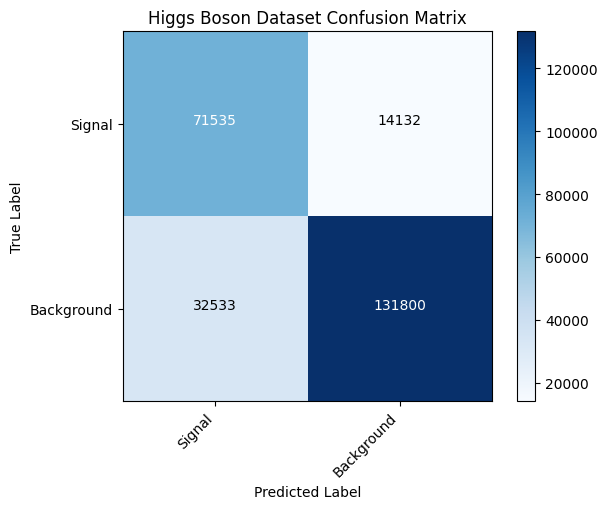

In [3]:
conf_matrix = loaded_cm

# 시각화
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Higgs Boson Dataset Confusion Matrix')
plt.colorbar()

classes = ['Signal', 'Background']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 각 셀에 숫자 표시
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(int(conf_matrix[i, j])),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black",
                 fontsize=10)  # 숫자의 글자 크기 조절

plt.show()
